In [38]:
%reload_ext autoreload
#!pip install -r requirements.txt

In [39]:
%autoreload
from architectures.timegan_cnn_DG import *
from utils import *
from trainers import *
import numpy as np
np.random.seed(42)

trainset = TimeGANDatasetSinus(num=600, seq_len=100, alpha=0.7, noise=0)
testset = TimeGANDatasetSinus(num=300, seq_len=100, alpha=0.7, noise=0)
print(len(trainset))
print(trainset[0][0].size())


600
torch.Size([100, 3])


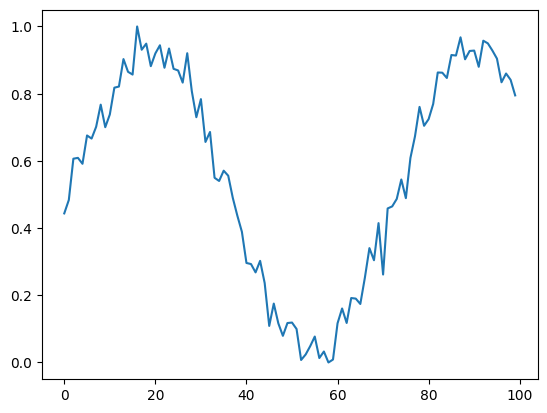

In [40]:
plt.plot(trainset[0][0][:,0])

In [ ]:
%autoreload
import neptune.new as neptune
import torch

run = neptune.init_run(
    project="kohmann/timeGAN",
    name="timegan_cnn_DG",
    tags=["cnn","DG"],
    description="flipped to:  mse(H[:, :-1, :], H_hat_supervise[:, 1:, :])",
    source_files=["timegan_cnn_DG.py"],
    capture_hardware_metrics=False,
    api_token="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiI3YjFjNGY5MS1kOWU1LTRmZjgtOTNiYS0yOGI2NDdjZGYzNWUifQ==",
)


device = "cuda" if torch.cuda.is_available() else "cpu"

params = {
    "model_name": "model_cnn_dg_supervised_test2.pt",
    "n_epochs": 1500,
    "l_rate": 0.001,
    "batch_size": 64,
    "num_layers": 2,
    "hidden_dim": 20,
    "Z_dim": 100,
    "dis_thresh": 0.15,
    "dataset": "sinus",
    "feature_dim": trainset[0][0].size(1),
    "max_seq_len": trainset[0][0].size(0),
    "trainset_size": len(trainset),
    "device": device,
    "optimizer": "Adam",
}
run["parameters"] = params

model = TimeGAN(feature_dim=params["feature_dim"],
                hidden_dim=params["hidden_dim"],
                num_layers=params["num_layers"],
                padding_value=0.,
                Z_dim=params["Z_dim"],
                max_seq_len=params["max_seq_len"],
                batch_size=params["batch_size"],
                device=torch.device(params["device"]))

timegan_trainer(model,
                trainset,
                batch_size=params["batch_size"],
                device=torch.device(params["device"]),
                learning_rate=params["l_rate"],
                n_epochs=params["n_epochs"],
                max_seq_len=params["max_seq_len"],
                dis_thresh=params["dis_thresh"],
                neptune_logger=run,
                model_name=params["model_name"]
                )
# Generate random synthetic data
gen_z = timegan_generator(model, torch.tensor(testset.T), params["model_name"], torch.device(device), testset[0][0].size(0), 100)

log_visualizations(testset, gen_z, run) # logs pca, tsne, umap, mode_collapse
run["model_checkpoint"].upload(params["model_name"])

run.stop()

https://app.neptune.ai/kohmann/timeGAN/e/TIMEGAN-137
Remember to stop your run once you’ve finished logging your metadata (https://docs.neptune.ai/api/run#stop). It will be stopped automatically only when the notebook kernel/interactive console is terminated.

Start Embedding Network Training


Epoch: 1499, Loss: 0.0037: 100%|██████████| 1500/1500 [04:37<00:00,  5.40it/s]



Start Training with Supervised Loss Only


Epoch: 1499, Loss: 0.0015: 100%|██████████| 1500/1500 [03:20<00:00,  7.50it/s]



Start Joint Training


Epoch: 947, E: 0.1410, G: 5.4406, D: 0.8379:  63%|██████▎   | 948/1500 [20:42<10:49,  1.18s/it]

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"

params = {
    "model_name": "model_cnn_dg_e0_98_trial2.pt",
    "n_epochs": 2000,
    "l_rate": 0.001,
    "batch_size": 64,
    "num_layers": 2,
    "hidden_dim": 20,
    "Z_dim": 100,
    "dis_thresh": 0.15,
    "dataset": "sinus",
    "feature_dim": trainset[0][0].size(1),
    "max_seq_len": trainset[0][0].size(0),
    "trainset_size": len(trainset),
    "device": device,
    "optimizer": "Adam",
}
model = TimeGAN(feature_dim=params["feature_dim"],
                hidden_dim=params["hidden_dim"],
                num_layers=params["num_layers"],
                padding_value=0.,
                Z_dim=params["Z_dim"],
                max_seq_len=params["max_seq_len"],
                batch_size=params["batch_size"],
                device=torch.device(params["device"]))
gen_z = timegan_generator(model, torch.tensor(testset.T), "model_cnn_dg_e0_98_trial2.pt", torch.device(device), testset[0][0].size(0),
                          100)

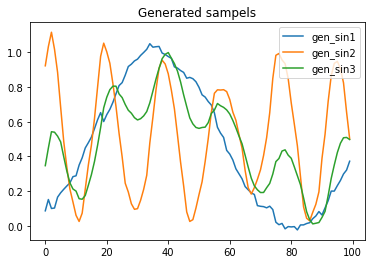

In [6]:
sample = 10
plt.plot(gen_z[sample][:, 0], label="gen_sin1")
plt.plot(gen_z[sample][:, 1], label="gen_sin2")
plt.plot(gen_z[sample][:, 2], label="gen_sin3")
plt.title("Generated sampels")
plt.legend()

In [6]:
def create_sin3(sin1, sin2, temporal=False):
    sin1, sin2 = np.array(sin1), np.array(sin2)
    e = 0.7  # temporal information weight
    seq_len = len(sin1)
    importance = np.array([e ** i for i in range(seq_len)])

    if temporal:
        sin3 = []
        for i in range(1, seq_len + 1):
            sin3.append(((importance[:i][::-1] * sin1[:i] + importance[:i][::-1] * sin2[:i]) / 2).sum())
        return sin3
    else:
        return [(s1 + s2) / 2 for s1, s2 in zip(sin1, sin2)]

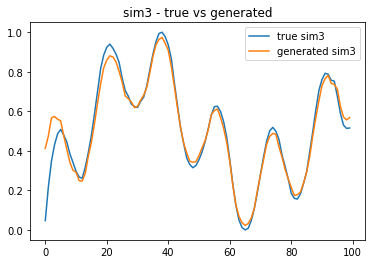

In [8]:
sample = 6
real_combo = create_sin3(gen_z[sample][:,0], gen_z[sample][:,1], temporal=True)
real_comb_scaled = minmaxscaler().fit_transform(torch.tensor([real_combo]))[0]
gen_combo = gen_z[sample][:,2]
plt.plot(real_comb_scaled, label="true sim3")
plt.plot(gen_combo, label="generated sim3")
plt.title("sim3 - true vs generated")
plt.legend()

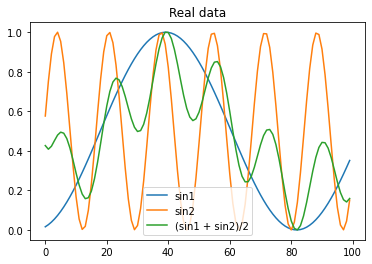

In [8]:
sample = trainset.__getitem__(9)
plt.plot(sample[0][:,0], label="sin1")
plt.plot(sample[0][:,1], label="sin2")
plt.plot(sample[0][:,2], label="(sin1 + sin2)/2")
plt.title("Real data")
plt.legend()

In [ ]:
real_comb = create_sin3(gen_z[sample][:,0], gen_z[sample][:,0], temporal=True)
real_comb_scaled = minmaxscaler().fit_transform(torch.tensor([real_combo]))
plt.plot(real_comb_scaled[0])

### CNN layer testing

In [ ]:
def printLayerShapes(layers, input):
    for layer in layers:
        output = layer(input)

        print(f"{type(layer).__name__:13}: {list(input.size())} --> {list(output.size())}")
        input = output

In [ ]:
import torch
import torch.nn as nn
hidden_dim = 20
max_seq_len = 100
input = torch.randn(2, max_seq_len, hidden_dim)


## Discriminator
layers = nn.Sequential(
            nn.Conv1d(in_channels=max_seq_len, out_channels=max_seq_len, kernel_size=(5), stride=2, bias=False)
            ,nn.BatchNorm1d(max_seq_len)
            ,nn.LeakyReLU()
            ,nn.Conv1d(in_channels=max_seq_len, out_channels=max_seq_len, kernel_size=(7), stride=2, bias=False)
            ,nn.Flatten(start_dim=1)
            ,nn.BatchNorm1d(max_seq_len)
            ,nn.LeakyReLU()
            ,nn.Linear(max_seq_len, 1)
        )
print(f"Discriminator architecture\nInput: {input.size()}\n")
printLayerShapes(layers, input)

In [ ]:
## Generator architecture
Z_dim = 50
hidden_dim = 20
max_seq_len = 100
input = torch.randn(2, max_seq_len, Z_dim)


layers = nn.Sequential(
            nn.Conv1d(in_channels=max_seq_len, out_channels=max_seq_len, kernel_size=3, stride=2, bias=False)
            , nn.BatchNorm1d(max_seq_len)
            , nn.LeakyReLU()
            , nn.Conv1d(in_channels=max_seq_len, out_channels=max_seq_len, kernel_size=5, stride=1, bias=True)
            , nn.Sigmoid()
        )

print(f"Generator architecture\nInput: {input.size()}\n")
printLayerShapes(layers, input)

In [ ]:
## Generator architecture LINEAR
Z_dim = 1
hidden_dim = 20
max_seq_len = 100
input = torch.randn(16, max_seq_len, Z_dim)
input = input.squeeze(dim=2)


layers = nn.Sequential(
            nn.Linear(in_features=100, out_features=200, bias=True)
            ,nn.LayerNorm(200)
            ,nn.LeakyReLU()
            ,nn.Linear(in_features=200, out_features=400, bias=True)
            ,nn.LayerNorm(400)
            ,nn.LeakyReLU()
            ,nn.Linear(in_features=200, out_features=1000, bias=True)
            ,nn.LayerNorm(400)
            ,nn.LeakyReLU()
        )


print(f"Generator architecture\nInput: {input.size()}\n")
printLayerShapes(layers, input)

In [ ]:
torch.randn(16,300).view(-1,100,3).size()